#### 시작

In [2]:
from dotenv import load_dotenv

import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

from pathlib import Path

import json

- .env라는 파일을 먼저 만들고, 기본 베이스 경로(root_path)를 .env가 들어있는 부모폴더로 해놓았습니다.
    - 따라서 .env(파일이름이 .env입니다.)를 먼저 만들어주시고 .env가 들어있는 폴더에 data폴더를 만들어주시고 그 안에 저희에게 주어진 json 파일과 images폴더가 있고 images폴더 안에 이미지 600장이 들어있는 구조이면 문제없이 작동할 것으로 보입니다!
- 자세한 폴더 구조는 저희 팀 깃허브 페이지에 들어가시면 리드미에서 구조도를 보실 수 있습니다.

In [5]:
class PathManager:
    """환경 및 모듈 간 규격 클래스"""
    """상황에 맞게 경로와 규격을 수정 후 사용할 것"""
    
    def __init__(self, default_size: int | None = None):
        """dotenv 위치 찾기 + 로드"""
        self.root_path = self._find_root()
        self.dotenv_path = self.root_path / ".env" # 또는 self.dotenv_path = self.root_path / ".env"
        load_dotenv(self.dotenv_path)

        """이미지와 모델 디렉토리 인식"""
        self._images_dir = self.root_path / "data/images"
        self._models_dir = self.root_path / "models"
        self._datas_dir = self.root_path / "data"
        self.default_size = default_size

        self.image_name = None
        self.model_name = None

    def _find_root(self, marker: str=".env") -> Path: # 외부에서 호출할 일 없다.
        """프로젝트 최상단 경로를 찾는 함수"""
        """.env를 마커로 사용"""
        current_cwd = Path().cwd().resolve()
        for parent in current_cwd.parents:
            if (parent / marker).exists():
                return parent

    def get_image_path(self, image_name: str) -> Path:
        """이미지 주소 획득"""
        self.image_name = image_name
        return self._images_dir / image_name
        
    def get_model_path(self, model_name: str) -> Path:
        """모델 주소 획득"""
        self.model_name = model_name
        return self._models_dir / model_name

    def get_data_path(self, data_name: str) -> Path:
        """데이터 주소 획득"""
        self.data_name = data_name
        return self._datas_dir / data_name

def run():
    """앞으로 작업할 모든 작업에서 쓰는 경로 반환 함수"""
    path_manager = PathManager()

    # 기본 경로, 이미지 폴더 경로, 데이터 폴더 경로
    root_path = path_manager.root_path
    images_dir = path_manager._images_dir
    data_dir = path_manager._datas_dir

    # 이미지 폴더 내의 이미지 경로
    my_image_path = path_manager.get_image_path("night ride (7).png")
    
    # 원본
    my_image_origin = cv2.imread(my_image_path)
    
    # 원본을 rgb로 변환 후 변수 저장
    my_image_rgb = cv2.cvtColor(my_image_origin, cv2.COLOR_BGR2RGB)

    # json 경로
    my_json_path = path_manager.get_data_path("COCO_motorcycle (pixel).json")
    
    # json 로드
    with open (my_json_path, "r", encoding="utf-8") as f:
        my_json_origin = json.load(f)

    return root_path, images_dir, data_dir, my_json_origin

# root_path: .env 파일의 부모 폴더, images_dir: 이미지 폴더 주소, data_dir: 데이터 폴더 주소, my_json_origin: json파일 객체
root_path, images_dir, data_dir, my_json_origin = run()

#### 폴더에 있는 이미지 파일 가져오기

In [ ]:
import os

# 1. 이미지 폴더 내의 모든 파일 리스트업
# PathManager의 속성을 활용합니다.
all_files = os.listdir(images_dir)

# 2. 이미지 확장자만 필터링 (순서가 달라도 상관없습니다, 이름으로 매칭할 거니까요)
valid_extensions = ('.png', '.jpg', '.jpeg')
image_files = [f for f in all_files if f.lower().endswith(valid_extensions)]

print(f"찾은 이미지 개수: {len(image_files)}장") # 여기서 200이 나와야 합니다.

찾은 이미지 개수: 600장


#### 폴더에 있는 이미지 파일 중 save랑 fuse 제외하고 가져오기

In [11]:
# 1. 'save'와 'fuse'가 이름에 들어간 파일은 제외하고 순수 'night ride'와 'Screenshot'만 추출
# 리스트 컴프리헨션을 사용하여 조건부 필터링을 수행합니다.
image_files = [
    f for f in all_files 
    if f.lower().endswith(valid_extensions)
    and 'save' not in f.lower() 
    and 'fuse' not in f.lower()
]

print(f"정제된 이미지 개수: {len(image_files)}장") 
# 여기서 정확히 200장이 나오는지 확인하십시오.

print(image_files[99])

정제된 이미지 개수: 200장
Screenshot (317).png


#### JSON과 입력파일이 실제로 매칭하는지 확인해서 매칭된것만 가져오기

In [12]:
# JSON에 등록된 모든 파일 이름을 집합(Set)으로 만듭니다. (검색 속도 최적화)
json_filenames = {img['file_name'] for img in my_json_origin['images']}

# 폴더에는 있지만 JSON에는 없는 유령 파일들을 걸러냅니다.
final_image_files = [f for f in image_files if f in json_filenames]

print(f"최종 매칭된 이미지 개수: {len(final_image_files)}장")

최종 매칭된 이미지 개수: 200장


In [ ]:
from sklearn.model_selection import train_test_split

# 0. 팀원들끼리 공유할떄 시드값이 고정되어도 기본 파일정렬은 os마다 다를 수 있습니다. 그래서 추가했습니다.
final_image_files = sorted(final_image_files)

# 1. 전체 200장에서 먼저 Test 20장(10%)을 분리합니다.
# 200 * 0.1 = 20
train_val_files, test_files = train_test_split(
    final_image_files, 
    test_size=0.1, 
    random_state=2026
)

# 2. 남은 180장에서 다시 Val 20장(약 11.1%)을 분리합니다.
# 180 * (20/180) = 20
train_files, val_files = train_test_split(
    train_val_files, 
    test_size=20/180, 
    random_state=2026
)

print(f"✅ 분리 완료 (Seed: 2026)")
print(f"훈련 데이터(Train): {len(train_files)}장")
print(f"검증 데이터(Val): {len(val_files)}장")
print(f"테스트 데이터(Test): {len(test_files)}장")

✅ 분리 완료 (Seed: 2026)
훈련 데이터(Train): 160장
검증 데이터(Val): 20장
테스트 데이터(Test): 20장


#### 데이터셋 정의

In [24]:
import cv2
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset


# 0번부터 5번까지 6개 클래스를 할당, 배경도 언Undrivable에 포함
CLASS_MAP = {
    'Undrivable': 0,
    'Road': 1,
    'Lane Mark': 2,
    'My bike': 3,
    'Rider': 4,
    'Moveable': 5
}
# 역매핑 (ID -> Name)은 필요할 때 내부에서 생성하거나 별도로 정의
ID_TO_NAME = {v: k for k, v in CLASS_MAP.items()}


class DeepLabDataset(Dataset):
    """데이터셋, 이미지 및 마스크크 리사이즈, 정규화, 텐서화 """

    def __init__(self, image_paths, json_data, class_map):
        self.image_paths = image_paths
        self.json_data = json_data
        self.class_map = class_map
        
        # 520x520 리사이즈 및 텐서 변환
        self.transform = A.Compose([
            A.Resize(528, 528, interpolation=cv2.INTER_LINEAR),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
        
        # 마스크 전용 리사이즈 (정수 값 유지를 위해 별도 처리하거나 Compose 내에서 mask_interpolation 설정)
        self.mask_resize = A.Resize(528, 528, interpolation=cv2.INTER_NEAREST)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """마스크 제너레이터 함수로 마스크 생성, 이미지와 마스크에 리사이즈 및 정규화 적용"""
        image_path = self.image_paths[idx]
        
        # 1. 원본 이미지 로드 및 bgr2rgb
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 2. 마스크 생성 (기존에 정의한 6개 클래스 로직)
        # 2. 1920x1080 원본 크기로 먼저 생성
        full_mask = self._generate_full_mask(image_path.name, (1080, 1920))

        # 3. 이미지와 마스크 동시 변환 -> Resize(528, 528) 적용
        transformed = self.mask_resize(image=image, mask=full_mask)
        transformed = self.transform(image=transformed['image'], mask=transformed['mask'])

        return transformed['image'], transformed['mask'].long()

    def _generate_full_mask(self, file_name, shape):
        """JSON의 좌표를 기반으로 1080x1920 마스크 생성"""
        mask = np.zeros(shape, dtype=np.uint8)
        
        # 1. file_name으로 image_id 찾기
        image_info = next((img for img in self.json_data['images'] if img['file_name'] == file_name), None)
        if image_info is None:
            return mask
        
        image_id = image_info['id']
        
        # 2. 해당 image_id를 가진 모든 annotation 가져오기
        annotations = [ann for ann in self.json_data['annotations'] if ann['image_id'] == image_id]
        
        # 3. 카테고리 ID -> 이름 -> 인덱스(0~5) 매핑
        category_id_to_name = {cat['id']: cat['name'] for cat in self.json_data['categories']}
        
        for ann in annotations:
            cat_name = category_id_to_name.get(ann['category_id'])
            label_idx = self.class_map.get(cat_name)
            
            if label_idx is not None:
                for seg in ann['segmentation']:
                    # COCO 포맷의 폴리곤 [x1, y1, x2, y2...]을 numpy 배열로 변환
                    poly = np.array(seg).reshape((-1, 1, 2)).astype(np.int32)
                    # 해당 영역을 label_idx로 채움
                    cv2.fillPoly(mask, [poly], color=label_idx)                    
        return mask



#### 내가 설정한 클래스맵과 json 내부의 클래스명 일치여부 확인

In [28]:
def check_categories(json_data):
    """위에서 정의한 CLASS_MAP객체의 키들이 JSON의 카테고리와 철자가 정확하게 맞는지 확인인"""
    # JSON 내부에 실제 등록된 카테고리 이름들 추출
    json_cat_names = [cat['name'] for cat in json_data.get('categories', [])]    
    print(f"JSON 내 카테고리: {json_cat_names}")
    
    # 위에서 정의한 CLASS_MAP과 비교
    for name in CLASS_MAP.keys():
        if name not in json_cat_names:
            print(f"⚠️ 경고: '{name}' 클래스가 JSON에 존재하지 않습니다. 철자를 확인하세요.")
        else:
            print(f"✅ 확인: '{name}' 매칭 완료.")

# 실행
check_categories(my_json_origin)

JSON 내 카테고리: ['Rider', 'My bike', 'Moveable', 'Lane Mark', 'Road', 'Undrivable']
✅ 확인: 'Undrivable' 매칭 완료.
✅ 확인: 'Road' 매칭 완료.
✅ 확인: 'Lane Mark' 매칭 완료.
✅ 확인: 'My bike' 매칭 완료.
✅ 확인: 'Rider' 매칭 완료.
✅ 확인: 'Moveable' 매칭 완료.


#### 데이터 로더 정의 (데이터셋을 제공하는 함수, loader 들을 반환)

In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

def get_loaders(images_dir, json_origin, class_map, batch_size=4):
    """위에서 PathManager 인스턴스 들이 반환한 경로 및 객체들을 인자로 입력"""

    # 해당 디렉토리와 하위 디렉토리의 모든 특정 확장자 파일을 검색 후 리스트 생성
    all_files = list(images_dir.glob("**/*.png"))

    # 2. all_files 중 'fuse'나 'save'가 경로(폴더명 포함)에 들어있는 파일 제외 후 원본 이미지만 담긴 리스트 생성
    images_path_origin = sorted([p for p in all_files if "fuse" not in str(p).lower() and "save" not in str(p).lower()])
    
    # 2. 데이터셋 분할 (160 : 20 : 20)
    train_paths, temp_paths = train_test_split(images_path_origin, train_size=160, test_size=40, random_state=42)
    val_paths, test_paths = train_test_split(temp_paths, train_size=20, test_size=20, random_state=42)

    # 3. 데이터셋 인스턴스 생성
    train_dataset = DeepLabDataset(train_paths, json_origin, class_map)
    val_dataset = DeepLabDataset(val_paths, json_origin, class_map)
    test_dataset = DeepLabDataset(test_paths, json_origin, class_map)

    # 4. 데이터로더 생성 (images, masks 구성), (batch, shuffle 결정)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(len(images_path_origin))

    return train_loader, val_loader, test_loader

# 실행 예시
train_loader, val_loader, test_loader = get_loaders(images_dir, my_json_origin, CLASS_MAP)



200


In [33]:
# 첫 번째 배치 규격 확인
images, masks = next(iter(train_loader))

print(f"이미지 배치 크기: {images.shape}") # [4, 3, 528, 528] (Batch, Channel, H, W)
print(f"마스크 배치 크기: {masks.shape}") # [4, 528, 528] (Batch, H, W)
print(f"마스크 내 고유 값: {torch.unique(masks)}") # [0, 1, 2, 3, 4, 5] (사전에 정한 클래스 번호)

이미지 배치 크기: torch.Size([4, 3, 528, 528])
마스크 배치 크기: torch.Size([4, 528, 528])
마스크 내 고유 값: tensor([0, 1, 2, 3, 4, 5])


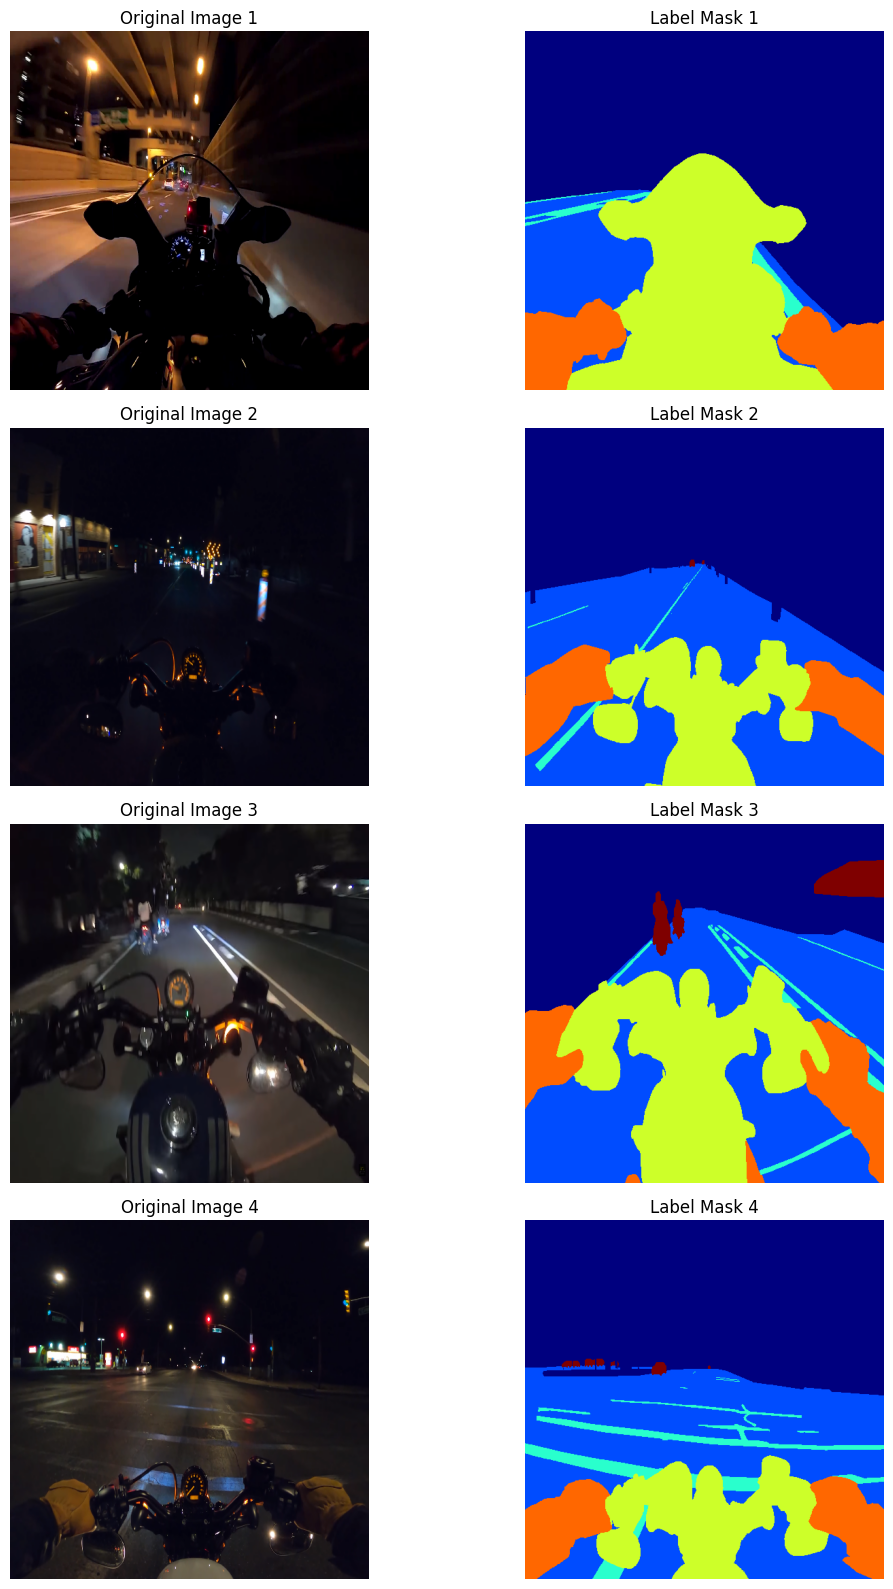

In [35]:
import matplotlib.pyplot as plt

def visualize_batch(loader, class_map):
    """마스크가 제대로 생성되었는지 시각화"""
    # 1. 배치 하나 추출
    images, masks = next(iter(loader))
    
    # 역매핑 생성 (숫자 -> 클래스 이름)
    id_to_name = {v: k for k, v in class_map.items()}
    
    # 시각화 설정 (4장 기준)
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))
    
    for i in range(4):
        # 이미지 전처리(Normalize) 되돌리기 (시각화 용도)
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        # 마스크 데이터
        mask = masks[i].numpy()
        
        # 출력
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Original Image {i+1}")
        axes[i, 0].axis('off')
        
        # 마스크 시각화 (클래스별로 색이 다르게 보이도록 cmap 설정)
        im = axes[i, 1].imshow(mask, cmap='jet', vmin=0, vmax=len(class_map)-1)
        axes[i, 1].set_title(f"Label Mask {i+1}")
        axes[i, 1].axis('off')
        
    plt.tight_layout()
    plt.show()

# 실행
visualize_batch(train_loader, CLASS_MAP)

#### 제대로 들어가는지 확인하기 위한 모델 정의

In [36]:
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(
    encoder_name="resnet34", 
    encoder_weights="imagenet", 
    in_channels=3, 
    classes=6  # 사전에 정한 6개 클래스에 맞춰 모델 생성
)

In [37]:
import torch.nn as nn
import torch.optim as optim


# 가장 기본적이면서도 확실한 기준
criterion = nn.CrossEntropyLoss() 

# 학습률(lr=0.0001)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

In [ ]:
# 1. 장치 설정: GPU가 있으면 cuda, 없으면 cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"현재 사용 중인 장치: {device}")

# 2. 모델을 해당 장치로 이동
model = model.to(device)

# 3. 학습 루프 내부에서도 데이터를 이동시켜야 함
for images, masks in train_loader:
    images = images.to(device)
    masks = masks.to(device)
    
    outputs = model(images)

    loss = criterion(outputs, masks)  # 예측값과 정답(mask) 비교
    
    loss.backward()  # 오류 역전파
    optimizer.step()  # 모델 업데이트

현재 사용 중인 장치: cuda


#### 데이터 증강 추가

In [86]:
import cv2
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset


# 0번부터 5번까지 6개 클래스를 할당, 배경도 언Undrivable에 포함
CLASS_MAP = {
    'Undrivable': 0,
    'Road': 1,
    'Lane Mark': 2,
    'My bike': 3,
    'Rider': 4,
    'Moveable': 5
}
# 역매핑 (ID -> Name)은 필요할 때 내부에서 생성하거나 별도로 정의
ID_TO_NAME = {v: k for k, v in CLASS_MAP.items()}


class DeepLabDataset(Dataset):
    """데이터셋, 이미지 및 마스크크 리사이즈, 정규화, 텐서화 """

    def __init__(self, image_paths, json_data, class_map):
        self.image_paths = image_paths
        self.json_data = json_data
        self.class_map = class_map
        
        # 520x520 리사이즈 및 텐서 변환
        self.transform = A.Compose([
            # 0. 리사이징 (528, 528)
            A.Resize(768, 768, interpolation=cv2.INTER_LINEAR),            
            # 1. 야간 노이즈 대응 (Gaussian Noise) - "야간 데이터의 특성을 고려했습니다"
            A.GaussNoise(p=0.2),            
            # 2. 오토바이의 좌우 주행 가변성 (Horizontal Flip)
            A.HorizontalFlip(p=0.5),            
            # 3. 조명 변화 대응 (Random Brightness/Contrast)
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
            # 4. 정규화
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            # 5. 텐서화
            ToTensorV2()
        ])
        
        # 마스크 전용 리사이즈 (정수 값 유지를 위해 별도 처리하거나 Compose 내에서 mask_interpolation 설정)
        # self.mask_resize = A.Resize(528, 528, interpolation=cv2.INTER_NEAREST)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """마스크 제너레이터 함수로 마스크 생성, 이미지와 마스크에 리사이즈 및 정규화 적용"""
        image_path = self.image_paths[idx]
        
        # 1. 원본 이미지 로드 및 bgr2rgb
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 2. 마스크 생성 (기존에 정의한 6개 클래스 로직)
        # 2. 1920x1080 원본 크기로 먼저 생성
        full_mask = self._generate_full_mask(image_path.name, (1080, 1920))

        # 3. 이미지와 마스크 동시 변환 -> Resize(528, 528) 적용
        # 이 한 줄이 이미지와 마스크를 동기화시킵니다.
        transformed = self.transform(image=image, mask=full_mask)
        
        # 결과물에서 각각 꺼내면 이미 동기화된 상태입니다.
        image = transformed['image']
        mask = transformed['mask']
        
        return image, mask.long()

    def _generate_full_mask(self, file_name, shape):
        """JSON의 좌표를 기반으로 1080x1920 마스크 생성"""
        mask = np.zeros(shape, dtype=np.uint8)
        
        # 1. file_name으로 image_id 찾기
        image_info = next((img for img in self.json_data['images'] if img['file_name'] == file_name), None)
        if image_info is None:
            return mask
        
        image_id = image_info['id']
        
        # 2. 해당 image_id를 가진 모든 annotation 가져오기
        annotations = [ann for ann in self.json_data['annotations'] if ann['image_id'] == image_id]
        
        # 3. 카테고리 ID -> 이름 -> 인덱스(0~5) 매핑
        category_id_to_name = {cat['id']: cat['name'] for cat in self.json_data['categories']}
        
        for ann in annotations:
            cat_name = category_id_to_name.get(ann['category_id'])
            label_idx = self.class_map.get(cat_name)
            
            if label_idx is not None:
                for seg in ann['segmentation']:
                    # COCO 포맷의 폴리곤 [x1, y1, x2, y2...]을 numpy 배열로 변환
                    poly = np.array(seg).reshape((-1, 1, 2)).astype(np.int32)
                    # 해당 영역을 label_idx로 채움
                    cv2.fillPoly(mask, [poly], color=label_idx)                    
        return mask



In [87]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

def get_loaders(images_dir, json_origin, class_map, batch_size=4):
    """위에서 PathManager 인스턴스 들이 반환한 경로 및 객체들을 인자로 입력"""

    # 해당 디렉토리와 하위 디렉토리의 모든 특정 확장자 파일을 검색 후 리스트 생성
    all_files = list(images_dir.glob("**/*.png"))

    # 2. all_files 중 'fuse'나 'save'가 경로(폴더명 포함)에 들어있는 파일 제외 후 원본 이미지만 담긴 리스트 생성
    images_path_origin = sorted([p for p in all_files if "fuse" not in str(p).lower() and "save" not in str(p).lower()])
    
    # 2. 데이터셋 분할 (160 : 20 : 20)
    train_paths, temp_paths = train_test_split(images_path_origin, train_size=160, test_size=40, random_state=42)
    val_paths, test_paths = train_test_split(temp_paths, train_size=20, test_size=20, random_state=42)

    # 3. 데이터셋 인스턴스 생성
    train_dataset = DeepLabDataset(train_paths, json_origin, class_map)
    val_dataset = DeepLabDataset(val_paths, json_origin, class_map)
    test_dataset = DeepLabDataset(test_paths, json_origin, class_map)

    # 4. 데이터로더 생성 (images, masks 구성), (batch, shuffle 결정)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(len(images_path_origin))

    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset

# 로더 정의 완료 (train(160), val(20), test(20))
train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = get_loaders(images_dir, my_json_origin, CLASS_MAP)



200


In [88]:
next(iter(train_loader))


[tensor([[[[-1.7240, -1.7240, -1.6898,  ..., -1.8268, -1.8268, -1.8268],
           [-1.7412, -1.7412, -1.7240,  ..., -1.8268, -1.8268, -1.8268],
           [-1.7412, -1.7412, -1.7412,  ..., -1.8268, -1.8268, -1.8268],
           ...,
           [-1.4500, -1.4672, -1.4672,  ..., -1.7069, -1.7069, -1.7069],
           [-1.4843, -1.4843, -1.4672,  ..., -1.7069, -1.7069, -1.7069],
           [-1.6384, -1.6555, -1.6555,  ..., -1.8097, -1.8097, -1.8097]],
 
          [[-1.6681, -1.6681, -1.6506,  ..., -1.7731, -1.7731, -1.7731],
           [-1.6681, -1.6681, -1.6506,  ..., -1.7731, -1.7731, -1.7731],
           [-1.6681, -1.6681, -1.6681,  ..., -1.7731, -1.7731, -1.7731],
           ...,
           [-1.4405, -1.4405, -1.4405,  ..., -1.7206, -1.7206, -1.7206],
           [-1.4755, -1.4580, -1.4580,  ..., -1.7381, -1.7206, -1.7206],
           [-1.6331, -1.6331, -1.6331,  ..., -1.8081, -1.8081, -1.8081]],
 
          [[-1.1944, -1.1944, -1.1770,  ..., -1.2990, -1.2990, -1.2990],
           [-

#### 증강된 데이터 시각화

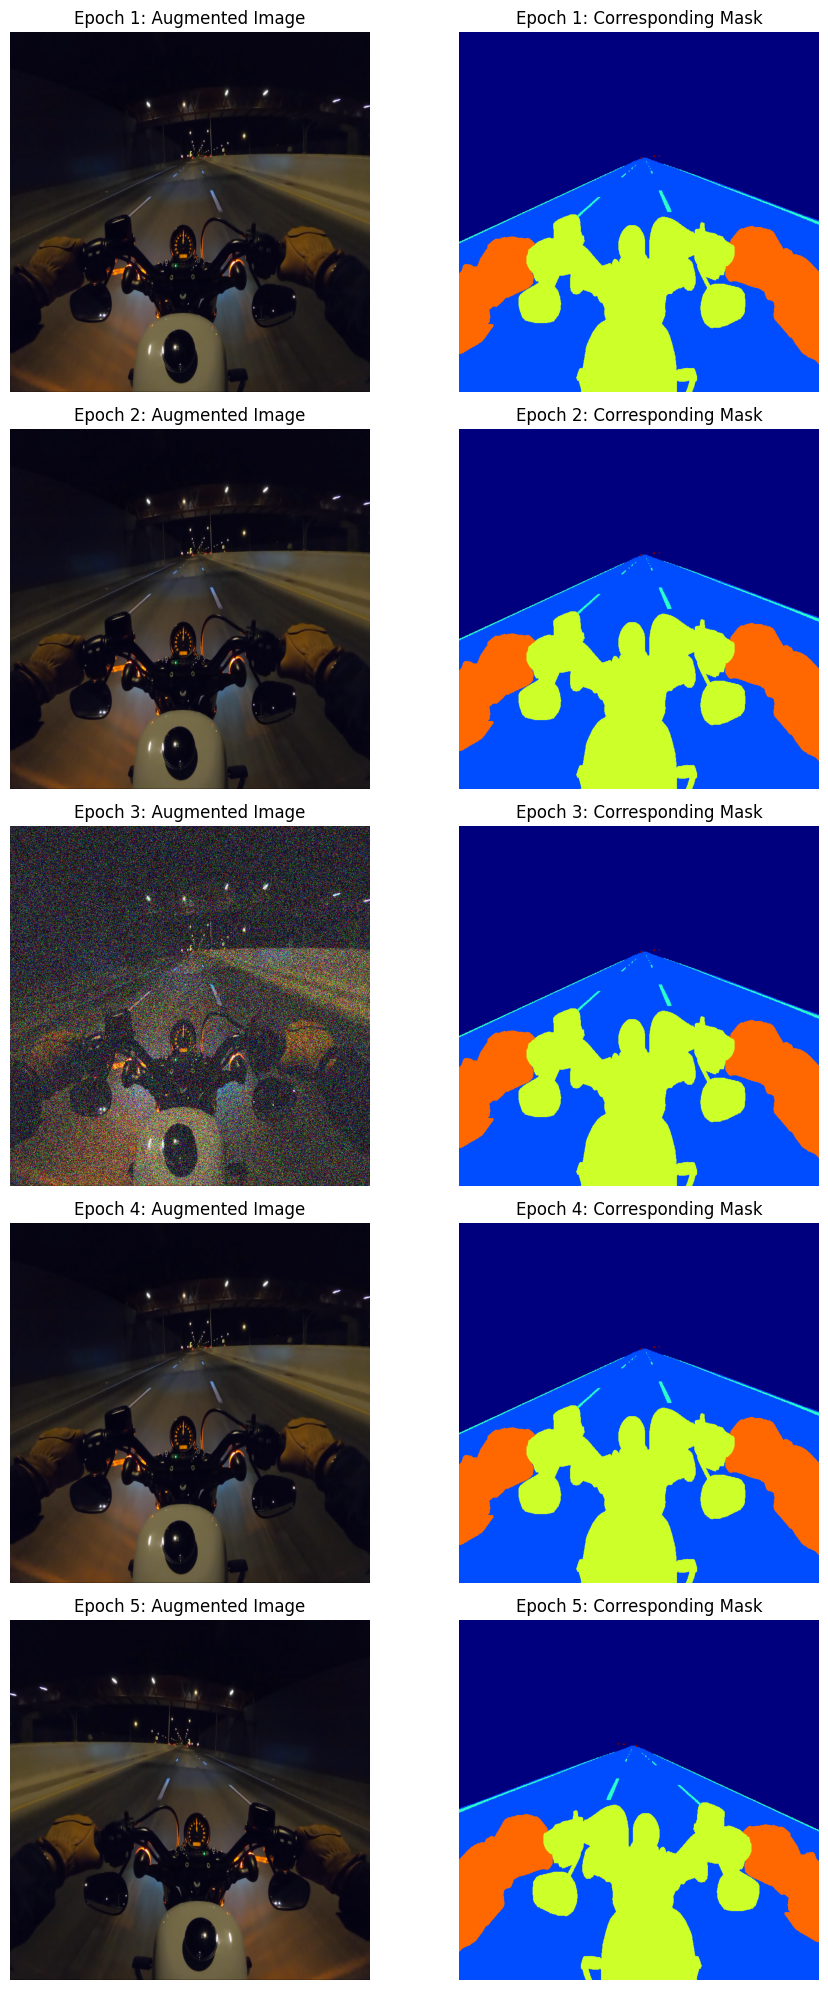

In [89]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_augmentation_epochs(dataset, sample_idx=0, num_epochs=5):
    """동일한 샘플이 에포크마다 어떻게 변하는지 시각화"""
    fig, axes = plt.subplots(nrows=num_epochs, ncols=2, figsize=(10, 20))
    
    for epoch in range(num_epochs):
        # 동일한 인덱스를 호출하지만, 내부 transform의 p(확률)에 의해 매번 결과가 다름
        image, mask = dataset[sample_idx]
        
        # 시각화를 위한 역정규화 (Normalize 되돌리기)
        img = image.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        # 마스크 데이터
        mask = mask.numpy()
        
        # 출력
        axes[epoch, 0].imshow(img)
        axes[epoch, 0].set_title(f"Epoch {epoch+1}: Augmented Image")
        axes[epoch, 0].axis('off')
        
        axes[epoch, 1].imshow(mask, cmap='jet')
        axes[epoch, 1].set_title(f"Epoch {epoch+1}: Corresponding Mask")
        axes[epoch, 1].axis('off')
        
    plt.tight_layout()
    plt.show()

# 실행 (이미 생성된 train_ds 사용)
visualize_augmentation_epochs(train_dataset)

#### 쿠다

In [90]:
import torch

# 1. CUDA 가속 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 현재 활성화된 연산 장치: {device}")

🚀 현재 활성화된 연산 장치: cuda


#### 모델 정의

In [91]:
import segmentation_models_pytorch as smp

# 2. 모델 아키텍처 선언
# 종하 님이 정의한 6개 클래스(0~5)에 맞춰 'classes=6'을 정확히 명시합니다.
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",       # 백본 인코더
    encoder_weights="imagenet",   # ImageNet 사전 학습 가중치 사용
    in_channels=3,                # 입력 채널 (RGB)
    classes=6                     # 출력 클래스 개수 (Background 포함)
).to(device)

print("✅ DeepLabV3+ 모델 로드 및 GPU 전송 완료")

✅ DeepLabV3+ 모델 로드 및 GPU 전송 완료


#### 손실 함수와, 최적화 함수 정의

In [92]:
import torch.nn as nn
import torch.optim as optim

# # 3. Criterion: 다중 클래스 분류를 위한 표준 CrossEntropy
# # "나중에 클래스 불균형이 심하면 여기에 가중치를 추가할 예정입니다."
# criterion = nn.CrossEntropyLoss()

# [수정된 Criterion 모듈]
# 0: Undrivable, 1: Road, 2: Lane Mark, 3: My bike, 4: Rider, 5: Moveable
# 차선(2번)에 5.0의 가중치를, 라이더나 이동체에도 조금 더 가중치를 줍니다.

weights = torch.tensor([1.0, 1.0, 5.0, 1.0, 2.0, 2.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

print("⚖️ 클래스 불균형 해소를 위한 가중치 적용 완료 (Lane Mark x5.0)")

# 4. Optimizer: 수렴 속도가 빠르고 과적합 방지에 유리한 AdamW
# 초기 학습률(lr)은 전이 학습의 안정성을 위해 1e-4로 보수적으로 설정했습니다.
optimizer = optim.AdamW(
    model.parameters(), 
    lr=1e-4, 
    weight_decay=1e-2
)

# 5. Scheduler: 학습이 진행될수록 정교하게 가중치를 튜닝하도록 조절
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

⚖️ 클래스 불균형 해소를 위한 가중치 적용 완료 (Lane Mark x5.0)


#### miou 계산 함수 정의

In [ ]:
def get_metrics(model, loader, device, num_classes=6):
    """검증 루프에서 즉시 mIoU를 계산하여 반환하는 함수"""
    model.eval()
    intersection = torch.zeros(num_classes).to(device)
    union = torch.zeros(num_classes).to(device)
    
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1) # [B, 528, 528]
            
            for cls in range(num_classes):
                # 종하 님이 정의한 0~5번 클래스별로 교집합/합집합 계산
                inter = ((preds == cls) & (masks == cls)).sum()
                un = ((preds == cls) | (masks == cls)).sum()
                
                intersection[cls] += inter
                union[cls] += un
                
    iou = intersection / (union + 1e-7) # 0으로 나누기 방지
    miou = iou.mean().item()
    return miou, iou

#### 학습 시작

In [60]:
import os
from tqdm.auto import tqdm # 학습 진행률 표시

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=50):
    best_miou = 0.0
    
    for epoch in range(epochs):
        # --- [1] Training Phase ---
        model.train()
        train_loss = 0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        scheduler.step()
        
        # --- [2] Validation Phase (mIoU 계산) ---
        # "여기서 종하 님이 제안한 mIoU 기반 가중치 저장이 일어납니다."
        val_miou, _ = get_metrics(model, val_loader, device) # 이전 단계에서 정의한 함수
        
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f} | Val mIoU: {val_miou:.4f}")
        
        # --- [3] Model Checkpointing ---
        # "성능이 향상되었을 때만 가중치를 직렬화(Serialization)하여 저장합니다."
        if val_miou > best_miou:
            best_miou = val_miou
            torch.save(model.state_dict(), "best_deeplab_night.pth")
            print(f"⭐ Best Model Saved! (mIoU: {best_miou:.4f})")
            
    print(f"🏁 학습 완료. 최고 성적: {best_miou:.4f}")

# 함수 실행 (앞서 정의한 객체들 투입)
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device)

Epoch 1/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


Epoch [1/50] Train Loss: 0.9996 | Val mIoU: 0.4994
⭐ Best Model Saved! (mIoU: 0.4994)


Epoch 2/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.30it/s]


Epoch [2/50] Train Loss: 0.5001 | Val mIoU: 0.6054
⭐ Best Model Saved! (mIoU: 0.6054)


Epoch 3/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.28it/s]


Epoch [3/50] Train Loss: 0.3791 | Val mIoU: 0.6015


Epoch 4/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.96it/s]


Epoch [4/50] Train Loss: 0.3195 | Val mIoU: 0.6598
⭐ Best Model Saved! (mIoU: 0.6598)


Epoch 5/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.10it/s]


Epoch [5/50] Train Loss: 0.2765 | Val mIoU: 0.6266


Epoch 6/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.97it/s]


Epoch [6/50] Train Loss: 0.2710 | Val mIoU: 0.6367


Epoch 7/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.97it/s]


Epoch [7/50] Train Loss: 0.2472 | Val mIoU: 0.6396


Epoch 8/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.04it/s]


Epoch [8/50] Train Loss: 0.2300 | Val mIoU: 0.6768
⭐ Best Model Saved! (mIoU: 0.6768)


Epoch 9/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.09it/s]


Epoch [9/50] Train Loss: 0.2069 | Val mIoU: 0.6883
⭐ Best Model Saved! (mIoU: 0.6883)


Epoch 10/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.04it/s]


Epoch [10/50] Train Loss: 0.2005 | Val mIoU: 0.6676


Epoch 11/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.12it/s]


Epoch [11/50] Train Loss: 0.1832 | Val mIoU: 0.6974
⭐ Best Model Saved! (mIoU: 0.6974)


Epoch 12/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.06it/s]


Epoch [12/50] Train Loss: 0.1774 | Val mIoU: 0.7179
⭐ Best Model Saved! (mIoU: 0.7179)


Epoch 13/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.14it/s]


Epoch [13/50] Train Loss: 0.1714 | Val mIoU: 0.7122


Epoch 14/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.16it/s]


Epoch [14/50] Train Loss: 0.1603 | Val mIoU: 0.7242
⭐ Best Model Saved! (mIoU: 0.7242)


Epoch 15/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.30it/s]


Epoch [15/50] Train Loss: 0.1611 | Val mIoU: 0.7435
⭐ Best Model Saved! (mIoU: 0.7435)


Epoch 16/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.24it/s]


Epoch [16/50] Train Loss: 0.1559 | Val mIoU: 0.7138


Epoch 17/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.28it/s]


Epoch [17/50] Train Loss: 0.1456 | Val mIoU: 0.6960


Epoch 18/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.44it/s]


Epoch [18/50] Train Loss: 0.1408 | Val mIoU: 0.7119


Epoch 19/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.40it/s]


Epoch [19/50] Train Loss: 0.1418 | Val mIoU: 0.7296


Epoch 20/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.50it/s]


Epoch [20/50] Train Loss: 0.1289 | Val mIoU: 0.7466
⭐ Best Model Saved! (mIoU: 0.7466)


Epoch 21/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.37it/s]


Epoch [21/50] Train Loss: 0.1273 | Val mIoU: 0.7416


Epoch 22/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.30it/s]


Epoch [22/50] Train Loss: 0.1229 | Val mIoU: 0.7379


Epoch 23/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.31it/s]


Epoch [23/50] Train Loss: 0.1240 | Val mIoU: 0.7496
⭐ Best Model Saved! (mIoU: 0.7496)


Epoch 24/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.21it/s]


Epoch [24/50] Train Loss: 0.1251 | Val mIoU: 0.7685
⭐ Best Model Saved! (mIoU: 0.7685)


Epoch 25/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.24it/s]


Epoch [25/50] Train Loss: 0.1241 | Val mIoU: 0.7525


Epoch 26/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.14it/s]


Epoch [26/50] Train Loss: 0.1288 | Val mIoU: 0.7635


Epoch 27/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.15it/s]


Epoch [27/50] Train Loss: 0.1177 | Val mIoU: 0.7707
⭐ Best Model Saved! (mIoU: 0.7707)


Epoch 28/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.11it/s]


Epoch [28/50] Train Loss: 0.1118 | Val mIoU: 0.7592


Epoch 29/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.10it/s]


Epoch [29/50] Train Loss: 0.1107 | Val mIoU: 0.7486


Epoch 30/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.11it/s]


Epoch [30/50] Train Loss: 0.1094 | Val mIoU: 0.7380


Epoch 31/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.21it/s]


Epoch [31/50] Train Loss: 0.1048 | Val mIoU: 0.7520


Epoch 32/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.16it/s]


Epoch [32/50] Train Loss: 0.1024 | Val mIoU: 0.6952


Epoch 33/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.40it/s]


Epoch [33/50] Train Loss: 0.0984 | Val mIoU: 0.7831
⭐ Best Model Saved! (mIoU: 0.7831)


Epoch 34/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.24it/s]


Epoch [34/50] Train Loss: 0.1046 | Val mIoU: 0.7744


Epoch 35/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.12it/s]


Epoch [35/50] Train Loss: 0.1009 | Val mIoU: 0.7874
⭐ Best Model Saved! (mIoU: 0.7874)


Epoch 36/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.99it/s]


Epoch [36/50] Train Loss: 0.1044 | Val mIoU: 0.7632


Epoch 37/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.86it/s]


Epoch [37/50] Train Loss: 0.0984 | Val mIoU: 0.7509


Epoch 38/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.03it/s]


Epoch [38/50] Train Loss: 0.1016 | Val mIoU: 0.7429


Epoch 39/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.23it/s]


Epoch [39/50] Train Loss: 0.0937 | Val mIoU: 0.7832


Epoch 40/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.06it/s]


Epoch [40/50] Train Loss: 0.0950 | Val mIoU: 0.7754


Epoch 41/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.16it/s]


Epoch [41/50] Train Loss: 0.0993 | Val mIoU: 0.7316


Epoch 42/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.12it/s]


Epoch [42/50] Train Loss: 0.1035 | Val mIoU: 0.7683


Epoch 43/50 [Train]: 100%|██████████| 40/40 [00:08<00:00,  4.97it/s]


Epoch [43/50] Train Loss: 0.0988 | Val mIoU: 0.7638


Epoch 44/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.28it/s]


Epoch [44/50] Train Loss: 0.0926 | Val mIoU: 0.7627


Epoch 45/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.14it/s]


Epoch [45/50] Train Loss: 0.0951 | Val mIoU: 0.7768


Epoch 46/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.09it/s]


Epoch [46/50] Train Loss: 0.0975 | Val mIoU: 0.7719


Epoch 47/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.15it/s]


Epoch [47/50] Train Loss: 0.0968 | Val mIoU: 0.7467


Epoch 48/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.04it/s]


Epoch [48/50] Train Loss: 0.0963 | Val mIoU: 0.7750


Epoch 49/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.03it/s]


Epoch [49/50] Train Loss: 0.0966 | Val mIoU: 0.7759


Epoch 50/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.11it/s]


Epoch [50/50] Train Loss: 0.0946 | Val mIoU: 0.7618
🏁 학습 완료. 최고 성적: 0.7874


In [75]:
import torch
import numpy as np
from tabulate import tabulate # 표 형태 출력을 위해 (없으면 pip install tabulate)

def evaluate_per_class(model, loader, device, class_map):
    model.load_state_dict(torch.load("best_deeplab_night.pth"))
    model.eval()
    
    num_classes = len(class_map)
    id_to_name = {v: k for k, v in class_map.items()}
    
    intersection = torch.zeros(num_classes).to(device)
    union = torch.zeros(num_classes).to(device)
    
    print("🔍 검증 데이터셋 추론 시작...")
    
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            for cls in range(num_classes):
                inter = ((preds == cls) & (masks == cls)).sum()
                un = ((preds == cls) | (masks == cls)).sum()
                
                intersection[cls] += inter
                union[cls] += un
    
    # IoU 계산 (0으로 나누기 방지 epsilon 1e-7 추가)
    iou_per_class = intersection / (union + 1e-7)
    miou = iou_per_class.mean().item()
    
    # 결과 리포트 작성
    report_data = []
    for i in range(num_classes):
        report_data.append([i, id_to_name[i], f"{iou_per_class[i].item():.4f}"])
    
    print("\n" + "="*50)
    print(f"📊 Final Validation Report (mIoU: {miou:.4f})")
    print("="*50)
    print(tabulate(report_data, headers=["ID", "Class Name", "IoU"], tablefmt="grid"))
    print("="*50)

# 실행
evaluate_per_class(model, val_loader, device, CLASS_MAP)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2168\2776364474.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_deeplab_night.pth"))


🔍 검증 데이터셋 추론 시작...

📊 Final Validation Report (mIoU: 0.7855)
+------+--------------+--------+
|   ID | Class Name   |    IoU |
+======+==============+========+
|    0 | Undrivable   | 0.9227 |
+------+--------------+--------+
|    1 | Road         | 0.8398 |
+------+--------------+--------+
|    2 | Lane Mark    | 0.4466 |
+------+--------------+--------+
|    3 | My bike      | 0.9299 |
+------+--------------+--------+
|    4 | Rider        | 0.8808 |
+------+--------------+--------+
|    5 | Moveable     | 0.6929 |
+------+--------------+--------+


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2168\2725922506.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_deeplab_night.pth"))


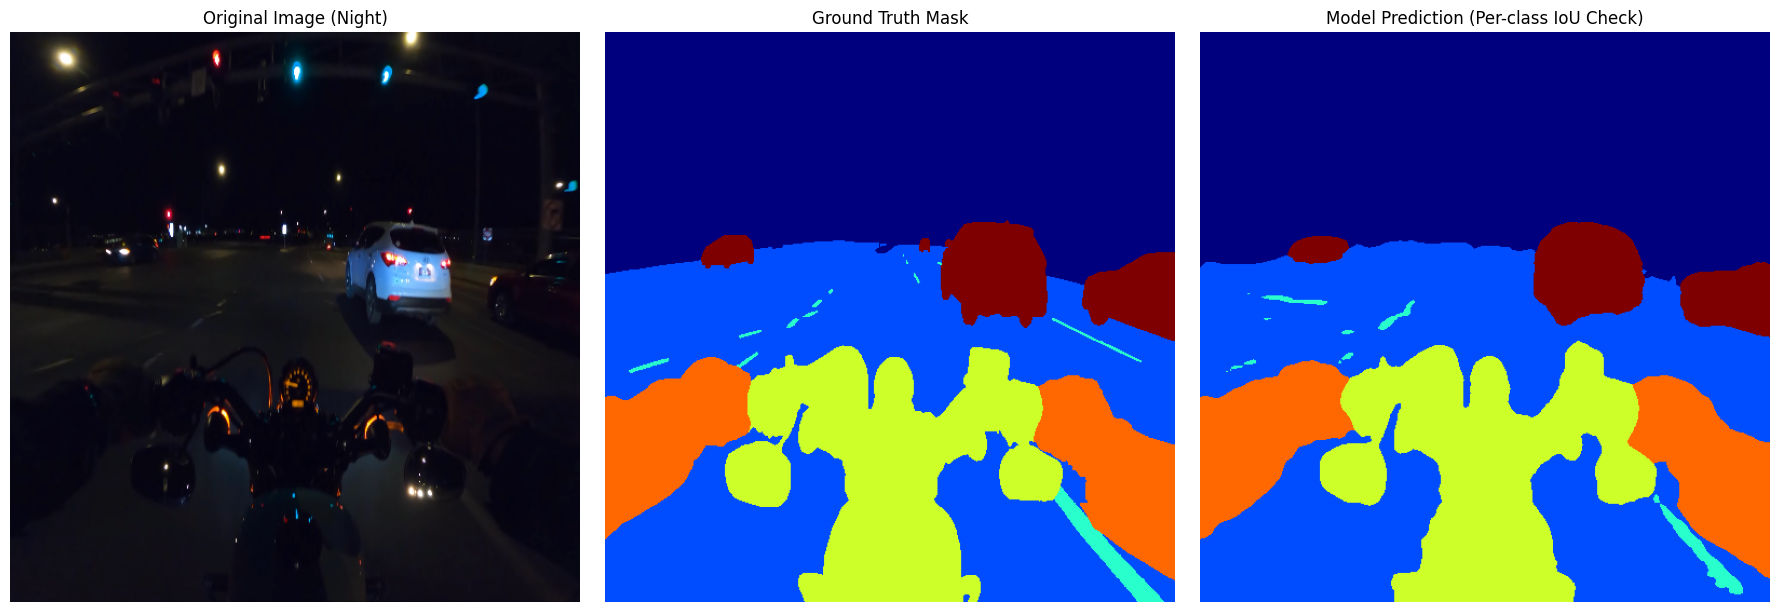

In [63]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_prediction(model, dataset, device, sample_idx=0):
    model.load_state_dict(torch.load("best_deeplab_night.pth"))
    model.eval()
    
    # 1. 데이터 가져오기
    image_tensor, mask_target = dataset[sample_idx]
    
    # 2. 모델 추론
    with torch.no_grad():
        input_tensor = image_tensor.unsqueeze(0).to(device)
        output = model(input_tensor)
        mask_pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    
    # 3. 시각화를 위한 역정규화
    img_show = image_tensor.permute(1, 2, 0).numpy()
    img_show = img_show * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_show = np.clip(img_show, 0, 1)
    
    # 4. 시각화 (원본 | 정답 | 예측)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(img_show)
    axes[0].set_title("Original Image (Night)")
    axes[0].axis('off')
    
    # 정답 마스크 (Lane Mark는 특정 색으로 강조됨)
    axes[1].imshow(mask_target, cmap='jet', vmin=0, vmax=5)
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')
    
    # 모델 예측 마스크
    axes[2].imshow(mask_pred, cmap='jet', vmin=0, vmax=5)
    axes[2].set_title(f"Model Prediction (Per-class IoU Check)")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# 실행: 검증 데이터셋 중 하나를 골라 확인
visualize_prediction(model, val_dataset, device, sample_idx=5)

#### 얼리스탑핑

In [93]:
class EarlyStopping:
    def __init__(self, patience=5, path='best_deeplab_night.pth'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_miou, model):
        if self.best_score is None:
            self.best_score = val_miou
            self.save_checkpoint(model)
        elif val_miou < self.best_score:
            self.counter += 1
            print(f"📉 EarlyStopping: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_miou
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)
        print(f"⭐ Best Model Saved! (mIoU: {self.best_score:.4f})")

In [74]:
import os
from tqdm.auto import tqdm # 학습 진행률 표시

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=50):

    early_stopping = EarlyStopping(patience=10)

    for epoch in range(epochs):
        # --- [1] Training Phase ---
        model.train()
        train_loss = 0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        scheduler.step()
        
        # --- [2] Validation Phase (mIoU 계산) ---
        # "여기서 종하 님이 제안한 mIoU 기반 가중치 저장이 일어납니다."
        val_miou, _ = get_metrics(model, val_loader, device) # 이전 단계에서 정의한 함수
        
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f} | Val mIoU: {val_miou:.4f}")
        
        # --- [3] Model Checkpointing ---
        # "성능이 향상되었을 때만 가중치를 직렬화(Serialization)하여 저장합니다."
        # if val_miou > best_miou:
        #     best_miou = val_miou
        #     torch.save(model.state_dict(), "best_deeplab_night.pth")
        #     print(f"⭐ Best Model Saved! (mIoU: {best_miou:.4f})")
        early_stopping(val_miou, model)
        
        if early_stopping.early_stop:
            print("🛑 조기 종료 조건 충족. 학습을 중단합니다.")
            break
        
    print(f"🏁 학습 완료. 최고 성적: {early_stopping.best_score:.4f}")

# 함수 실행 (앞서 정의한 객체들 투입)
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device)

Epoch 1/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.20it/s]


Epoch [1/50] Train Loss: 1.0750 | Val mIoU: 0.4891
⭐ Best Model Saved! (mIoU: 0.4891)


Epoch 2/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.44it/s]


Epoch [2/50] Train Loss: 0.5793 | Val mIoU: 0.5564
⭐ Best Model Saved! (mIoU: 0.5564)


Epoch 3/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.45it/s]


Epoch [3/50] Train Loss: 0.4700 | Val mIoU: 0.6372
⭐ Best Model Saved! (mIoU: 0.6372)


Epoch 4/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.36it/s]


Epoch [4/50] Train Loss: 0.3906 | Val mIoU: 0.6429
⭐ Best Model Saved! (mIoU: 0.6429)


Epoch 5/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.30it/s]


Epoch [5/50] Train Loss: 0.3781 | Val mIoU: 0.6938
⭐ Best Model Saved! (mIoU: 0.6938)


Epoch 6/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.49it/s]


Epoch [6/50] Train Loss: 0.3234 | Val mIoU: 0.6948
⭐ Best Model Saved! (mIoU: 0.6948)


Epoch 7/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.40it/s]


Epoch [7/50] Train Loss: 0.2815 | Val mIoU: 0.7074
⭐ Best Model Saved! (mIoU: 0.7074)


Epoch 8/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.30it/s]


Epoch [8/50] Train Loss: 0.2647 | Val mIoU: 0.6729
📉 EarlyStopping: 1 / 10


Epoch 9/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.30it/s]


Epoch [9/50] Train Loss: 0.2503 | Val mIoU: 0.7049
📉 EarlyStopping: 2 / 10


Epoch 10/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.31it/s]


Epoch [10/50] Train Loss: 0.2321 | Val mIoU: 0.7080
⭐ Best Model Saved! (mIoU: 0.7080)


Epoch 11/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.12it/s]


Epoch [11/50] Train Loss: 0.2345 | Val mIoU: 0.6748
📉 EarlyStopping: 1 / 10


Epoch 12/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.09it/s]


Epoch [12/50] Train Loss: 0.2165 | Val mIoU: 0.7236
⭐ Best Model Saved! (mIoU: 0.7236)


Epoch 13/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.33it/s]


Epoch [13/50] Train Loss: 0.2138 | Val mIoU: 0.7157
📉 EarlyStopping: 1 / 10


Epoch 14/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.47it/s]


Epoch [14/50] Train Loss: 0.1945 | Val mIoU: 0.7118
📉 EarlyStopping: 2 / 10


Epoch 15/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.38it/s]


Epoch [15/50] Train Loss: 0.1870 | Val mIoU: 0.7325
⭐ Best Model Saved! (mIoU: 0.7325)


Epoch 16/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.42it/s]


Epoch [16/50] Train Loss: 0.1801 | Val mIoU: 0.7223
📉 EarlyStopping: 1 / 10


Epoch 17/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.30it/s]


Epoch [17/50] Train Loss: 0.1880 | Val mIoU: 0.7649
⭐ Best Model Saved! (mIoU: 0.7649)


Epoch 18/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.30it/s]


Epoch [18/50] Train Loss: 0.1818 | Val mIoU: 0.7337
📉 EarlyStopping: 1 / 10


Epoch 19/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.50it/s]


Epoch [19/50] Train Loss: 0.1635 | Val mIoU: 0.7688
⭐ Best Model Saved! (mIoU: 0.7688)


Epoch 20/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.34it/s]


Epoch [20/50] Train Loss: 0.1674 | Val mIoU: 0.7491
📉 EarlyStopping: 1 / 10


Epoch 21/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.36it/s]


Epoch [21/50] Train Loss: 0.1708 | Val mIoU: 0.7486
📉 EarlyStopping: 2 / 10


Epoch 22/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.34it/s]


Epoch [22/50] Train Loss: 0.1537 | Val mIoU: 0.7732
⭐ Best Model Saved! (mIoU: 0.7732)


Epoch 23/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.41it/s]


Epoch [23/50] Train Loss: 0.1515 | Val mIoU: 0.7713
📉 EarlyStopping: 1 / 10


Epoch 24/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.41it/s]


Epoch [24/50] Train Loss: 0.1468 | Val mIoU: 0.7666
📉 EarlyStopping: 2 / 10


Epoch 25/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.41it/s]


Epoch [25/50] Train Loss: 0.1387 | Val mIoU: 0.7485
📉 EarlyStopping: 3 / 10


Epoch 26/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.46it/s]


Epoch [26/50] Train Loss: 0.1389 | Val mIoU: 0.7666
📉 EarlyStopping: 4 / 10


Epoch 27/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.46it/s]


Epoch [27/50] Train Loss: 0.1341 | Val mIoU: 0.7523
📉 EarlyStopping: 5 / 10


Epoch 28/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.44it/s]


Epoch [28/50] Train Loss: 0.1375 | Val mIoU: 0.7779
⭐ Best Model Saved! (mIoU: 0.7779)


Epoch 29/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.46it/s]


Epoch [29/50] Train Loss: 0.1293 | Val mIoU: 0.7695
📉 EarlyStopping: 1 / 10


Epoch 30/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.30it/s]


Epoch [30/50] Train Loss: 0.1292 | Val mIoU: 0.7674
📉 EarlyStopping: 2 / 10


Epoch 31/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.44it/s]


Epoch [31/50] Train Loss: 0.1310 | Val mIoU: 0.7643
📉 EarlyStopping: 3 / 10


Epoch 32/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.37it/s]


Epoch [32/50] Train Loss: 0.1313 | Val mIoU: 0.7621
📉 EarlyStopping: 4 / 10


Epoch 33/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.43it/s]


Epoch [33/50] Train Loss: 0.1278 | Val mIoU: 0.7843
⭐ Best Model Saved! (mIoU: 0.7843)


Epoch 34/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.31it/s]


Epoch [34/50] Train Loss: 0.1291 | Val mIoU: 0.7426
📉 EarlyStopping: 1 / 10


Epoch 35/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.30it/s]


Epoch [35/50] Train Loss: 0.1308 | Val mIoU: 0.7715
📉 EarlyStopping: 2 / 10


Epoch 36/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.44it/s]


Epoch [36/50] Train Loss: 0.1222 | Val mIoU: 0.7821
📉 EarlyStopping: 3 / 10


Epoch 37/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.38it/s]


Epoch [37/50] Train Loss: 0.1224 | Val mIoU: 0.7838
📉 EarlyStopping: 4 / 10


Epoch 38/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.30it/s]


Epoch [38/50] Train Loss: 0.1199 | Val mIoU: 0.7916
⭐ Best Model Saved! (mIoU: 0.7916)


Epoch 39/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


Epoch [39/50] Train Loss: 0.1207 | Val mIoU: 0.7708
📉 EarlyStopping: 1 / 10


Epoch 40/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.35it/s]


Epoch [40/50] Train Loss: 0.1140 | Val mIoU: 0.7546
📉 EarlyStopping: 2 / 10


Epoch 41/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.38it/s]


Epoch [41/50] Train Loss: 0.1200 | Val mIoU: 0.7745
📉 EarlyStopping: 3 / 10


Epoch 42/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.16it/s]


Epoch [42/50] Train Loss: 0.1230 | Val mIoU: 0.7853
📉 EarlyStopping: 4 / 10


Epoch 43/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.40it/s]


Epoch [43/50] Train Loss: 0.1107 | Val mIoU: 0.7742
📉 EarlyStopping: 5 / 10


Epoch 44/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.44it/s]


Epoch [44/50] Train Loss: 0.1183 | Val mIoU: 0.7590
📉 EarlyStopping: 6 / 10


Epoch 45/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.24it/s]


Epoch [45/50] Train Loss: 0.1207 | Val mIoU: 0.7846
📉 EarlyStopping: 7 / 10


Epoch 46/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.36it/s]


Epoch [46/50] Train Loss: 0.1190 | Val mIoU: 0.7696
📉 EarlyStopping: 8 / 10


Epoch 47/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.34it/s]


Epoch [47/50] Train Loss: 0.1151 | Val mIoU: 0.7652
📉 EarlyStopping: 9 / 10


Epoch 48/50 [Train]: 100%|██████████| 40/40 [00:07<00:00,  5.40it/s]


Epoch [48/50] Train Loss: 0.1130 | Val mIoU: 0.7788
📉 EarlyStopping: 10 / 10
🛑 조기 종료 조건 충족. 학습을 중단합니다.
🏁 학습 완료. 최고 성적: 0.7916


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2168\2725922506.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_deeplab_night.pth"))


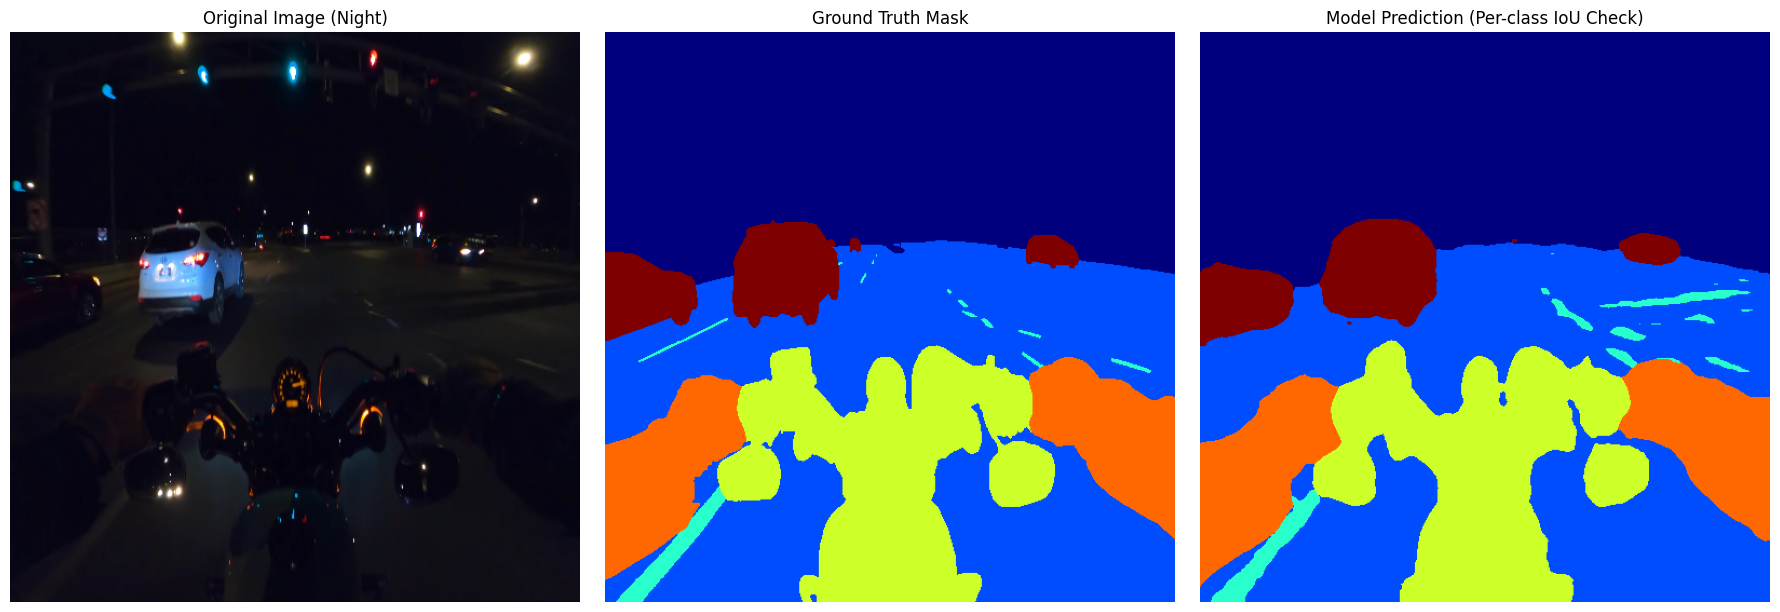

In [76]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_prediction(model, dataset, device, sample_idx=0):
    model.load_state_dict(torch.load("best_deeplab_night.pth"))
    model.eval()
    
    # 1. 데이터 가져오기
    image_tensor, mask_target = dataset[sample_idx]
    
    # 2. 모델 추론
    with torch.no_grad():
        input_tensor = image_tensor.unsqueeze(0).to(device)
        output = model(input_tensor)
        mask_pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    
    # 3. 시각화를 위한 역정규화
    img_show = image_tensor.permute(1, 2, 0).numpy()
    img_show = img_show * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_show = np.clip(img_show, 0, 1)
    
    # 4. 시각화 (원본 | 정답 | 예측)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(img_show)
    axes[0].set_title("Original Image (Night)")
    axes[0].axis('off')
    
    # 정답 마스크 (Lane Mark는 특정 색으로 강조됨)
    axes[1].imshow(mask_target, cmap='jet', vmin=0, vmax=5)
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')
    
    # 모델 예측 마스크
    axes[2].imshow(mask_pred, cmap='jet', vmin=0, vmax=5)
    axes[2].set_title(f"Model Prediction (Per-class IoU Check)")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# 실행: 검증 데이터셋 중 하나를 골라 확인
visualize_prediction(model, val_dataset, device, sample_idx=5)

#### miou, precision, recall 계산 함수 정의

In [94]:
def get_metrics(model, loader, device, num_classes=6):
    model.eval()
    # 지표 저장을 위한 텐서 초기화
    tp = torch.zeros(num_classes).to(device)
    fp = torch.zeros(num_classes).to(device)
    fn = torch.zeros(num_classes).to(device)
    
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            for cls in range(num_classes):
                # 핵심 지표 계산
                tp[cls] += ((preds == cls) & (masks == cls)).sum()
                fp[cls] += ((preds == cls) & (masks != cls)).sum()
                fn[cls] += ((preds != cls) & (masks == cls)).sum()
                
    # 0으로 나누기 방지용 epsilon
    eps = 1e-7
    
    # IoU, Precision, Recall 계산
    # IoU = TP / (TP + FP + FN)
    iou = tp / (tp + fp + fn + eps)
    # Precision = TP / (TP + FP)
    precision = tp / (tp + fp + eps)
    # Recall = TP / (TP + FN)
    recall = tp / (tp + fn + eps)
    
    miou = iou.mean().item()
    
    # 딕셔너리 형태로 리턴하면 나중에 파싱하기 아주 편리합니다.
    return {
        'miou': miou,
        'iou': iou,
        'precision': precision,
        'recall': recall
    }

#### miou와 pr curve에 대한 모델학습 코드

In [95]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=50):
    # 인스턴스 생성 시 patience=10으로 넉넉하게 기회를 준 점은 진취적입니다.
    early_stopping = EarlyStopping(patience=10)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        scheduler.step()
        
        # [수정] 딕셔너리 반환에 대응하는 안정적인 코드
        val_metrics = get_metrics(model, val_loader, device)
        val_miou = val_metrics['miou']
        
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f} | Val mIoU: {val_miou:.4f}")
        
        # 얼리스탑핑 모듈에 위임 (내부에서 저장 및 중단 판단)
        early_stopping(val_miou, model)
        
        if early_stopping.early_stop:
            print("🛑 Early Stopping triggered. Training halted.")
            break
            
    print(f"🏁 학습 완료. Best mIoU: {early_stopping.best_score:.4f}")

# 실행행
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device)

Epoch 1/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.64it/s]


Epoch [1/50] Train Loss: 1.0862 | Val mIoU: 0.5437
⭐ Best Model Saved! (mIoU: 0.5437)


Epoch 2/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.82it/s]


Epoch [2/50] Train Loss: 0.5644 | Val mIoU: 0.6269
⭐ Best Model Saved! (mIoU: 0.6269)


Epoch 3/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.83it/s]


Epoch [3/50] Train Loss: 0.4444 | Val mIoU: 0.6856
⭐ Best Model Saved! (mIoU: 0.6856)


Epoch 4/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.88it/s]


Epoch [4/50] Train Loss: 0.3569 | Val mIoU: 0.6831
📉 EarlyStopping: 1 / 10


Epoch 5/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.78it/s]


Epoch [5/50] Train Loss: 0.3205 | Val mIoU: 0.6985
⭐ Best Model Saved! (mIoU: 0.6985)


Epoch 6/50 [Train]: 100%|██████████| 40/40 [00:11<00:00,  3.63it/s]


Epoch [6/50] Train Loss: 0.2785 | Val mIoU: 0.7191
⭐ Best Model Saved! (mIoU: 0.7191)


Epoch 7/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.82it/s]


Epoch [7/50] Train Loss: 0.2454 | Val mIoU: 0.7104
📉 EarlyStopping: 1 / 10


Epoch 8/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.80it/s]


Epoch [8/50] Train Loss: 0.2457 | Val mIoU: 0.7330
⭐ Best Model Saved! (mIoU: 0.7330)


Epoch 9/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.82it/s]


Epoch [9/50] Train Loss: 0.2257 | Val mIoU: 0.7121
📉 EarlyStopping: 1 / 10


Epoch 10/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.77it/s]


Epoch [10/50] Train Loss: 0.2126 | Val mIoU: 0.7489
⭐ Best Model Saved! (mIoU: 0.7489)


Epoch 11/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.79it/s]


Epoch [11/50] Train Loss: 0.1993 | Val mIoU: 0.7368
📉 EarlyStopping: 1 / 10


Epoch 12/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.78it/s]


Epoch [12/50] Train Loss: 0.1934 | Val mIoU: 0.7538
⭐ Best Model Saved! (mIoU: 0.7538)


Epoch 13/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.75it/s]


Epoch [13/50] Train Loss: 0.1816 | Val mIoU: 0.7637
⭐ Best Model Saved! (mIoU: 0.7637)


Epoch 14/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


Epoch [14/50] Train Loss: 0.1757 | Val mIoU: 0.7389
📉 EarlyStopping: 1 / 10


Epoch 15/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.70it/s]


Epoch [15/50] Train Loss: 0.1739 | Val mIoU: 0.7496
📉 EarlyStopping: 2 / 10


Epoch 16/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.82it/s]


Epoch [16/50] Train Loss: 0.1472 | Val mIoU: 0.7595
📉 EarlyStopping: 3 / 10


Epoch 17/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.80it/s]


Epoch [17/50] Train Loss: 0.1513 | Val mIoU: 0.7916
⭐ Best Model Saved! (mIoU: 0.7916)


Epoch 18/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.81it/s]


Epoch [18/50] Train Loss: 0.1417 | Val mIoU: 0.7857
📉 EarlyStopping: 1 / 10


Epoch 19/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.77it/s]


Epoch [19/50] Train Loss: 0.1497 | Val mIoU: 0.7766
📉 EarlyStopping: 2 / 10


Epoch 20/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.82it/s]


Epoch [20/50] Train Loss: 0.1405 | Val mIoU: 0.7845
📉 EarlyStopping: 3 / 10


Epoch 21/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.76it/s]


Epoch [21/50] Train Loss: 0.1430 | Val mIoU: 0.7624
📉 EarlyStopping: 4 / 10


Epoch 22/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.76it/s]


Epoch [22/50] Train Loss: 0.1488 | Val mIoU: 0.7579
📉 EarlyStopping: 5 / 10


Epoch 23/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.77it/s]


Epoch [23/50] Train Loss: 0.1346 | Val mIoU: 0.7744
📉 EarlyStopping: 6 / 10


Epoch 24/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.82it/s]


Epoch [24/50] Train Loss: 0.1218 | Val mIoU: 0.7727
📉 EarlyStopping: 7 / 10


Epoch 25/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.78it/s]


Epoch [25/50] Train Loss: 0.1287 | Val mIoU: 0.7855
📉 EarlyStopping: 8 / 10


Epoch 26/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.75it/s]


Epoch [26/50] Train Loss: 0.1280 | Val mIoU: 0.7894
📉 EarlyStopping: 9 / 10


Epoch 27/50 [Train]: 100%|██████████| 40/40 [00:10<00:00,  3.77it/s]


Epoch [27/50] Train Loss: 0.1183 | Val mIoU: 0.7837
📉 EarlyStopping: 10 / 10
🛑 Early Stopping triggered. Training halted.
🏁 학습 완료. Best mIoU: 0.7916


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2168\1095487259.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_deeplab_night.pth"))


🧪 P-R 분석을 위한 추론 시작 (이 작업은 다소 시간이 소요될 수 있습니다)...


c:\Users\ADMIN\Documents\projects\team\Dlthon_01_Motocycle_Night_Ride\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ADMIN\Documents\projects\team\Dlthon_01_Motocycle_Night_Ride\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ADMIN\Documents\projects\team\Dlthon_01_Motocycle_Night_Ride\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ADMIN\Documents\projects\team\Dlthon_01_Motocycle_Night_Ride\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(byt

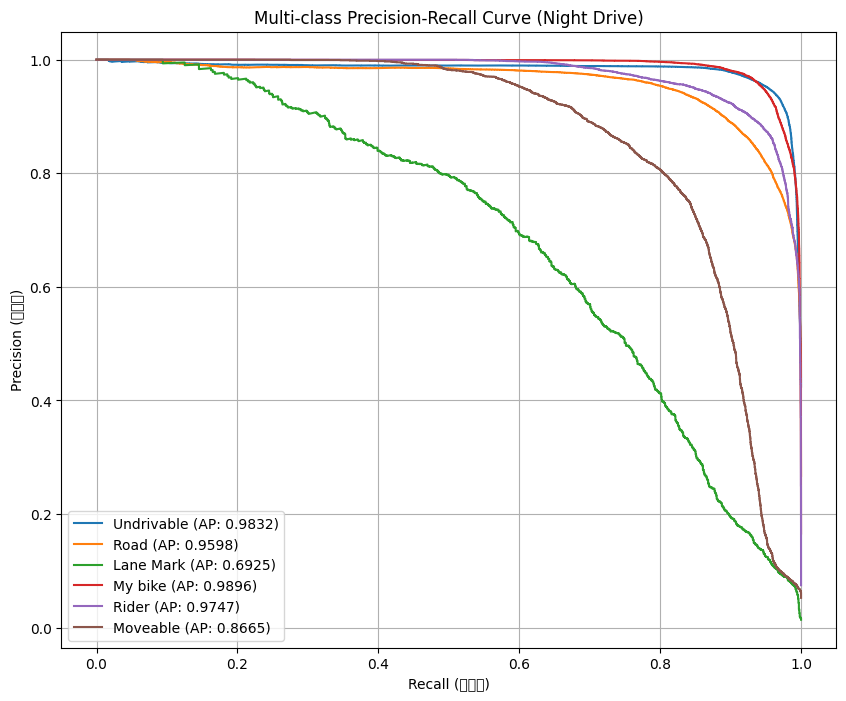

In [96]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curves(model, loader, device, num_classes=6, class_names=None):
    model.load_state_dict(torch.load("best_deeplab_night.pth"))
    model.eval()
    
    # 각 클래스별로 실제 값과 예측 확률을 저장할 리스트
    all_targets = [[] for _ in range(num_classes)]
    all_probs = [[] for _ in range(num_classes)]
    
    print("🧪 P-R 분석을 위한 추론 시작 (이 작업은 다소 시간이 소요될 수 있습니다)...")
    
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            # Softmax를 통과시켜 확률값(0~1)으로 변환
            probs = torch.softmax(outputs, dim=1)
            
            for cls in range(num_classes):
                # 해당 클래스에 대한 정답(1)과 오답(0) 바이너리 마스크
                target_cls = (masks == cls).float().cpu().numpy().flatten()
                prob_cls = probs[:, cls, :, :].cpu().numpy().flatten()
                
                # 메모리 효율을 위해 샘플링 (모든 픽셀을 다 넣으면 RAM 부족 위험)
                # 1/100 정도만 샘플링해도 경향성 파악에는 충분합니다.
                indices = np.random.choice(len(target_cls), len(target_cls)//100, replace=False)
                all_targets[cls].extend(target_cls[indices])
                all_probs[cls].extend(prob_cls[indices])

    # 그래프 그리기
    plt.figure(figsize=(10, 8))
    for cls in range(num_classes):
        precision, recall, _ = precision_recall_curve(all_targets[cls], all_probs[cls])
        ap = average_precision_score(all_targets[cls], all_probs[cls])
        
        name = class_names[cls] if class_names else f"Class {cls}"
        plt.plot(recall, precision, label=f'{name} (AP: {ap:.4f})')

    plt.xlabel('Recall (재현율)')
    plt.ylabel('Precision (정밀도)')
    plt.title('Multi-class Precision-Recall Curve (Night Drive)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# 실행 예시
CLASS_NAMES = ["Undrivable", "Road", "Lane Mark", "My bike", "Rider", "Moveable"]
plot_pr_curves(model, val_loader, device, num_classes=6, class_names=CLASS_NAMES)